# Pix2Pix GAN (style-based Pix2Pix GAN to be implemented)

**Materials:**

- [Machine Learning Mastery](https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/)

In [1]:
# fix imports
from fix_imports import fix_relative_imports
fix_relative_imports()

In [2]:
from keras.utils import plot_model

### Discriminator: PatchGAN 

Visualize and use model

In [3]:
from pix2pix_gan.discriminator import create_discriminator

image_shape = (256,256,3)
discriminator_model = create_discriminator(image_shape)
discriminator_model.summary()
# plot_model(discriminator_model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)


/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 6)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         6208      ['concatenate[0][0]']     

### Generator: U-Net

In [4]:
from pix2pix_gan.generator import create_generator

image_shape = (256,256,3)
generator_model = create_generator(image_shape)
generator_model.summary()
# plot_model(generator_model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 128, 128, 64)         3136      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 64, 64, 128)          131200    ['leaky_re_lu_5[0][0]']       
                                                                                            

## 3. GAN

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 256, 256, 3)          5442931   ['input_4[0][0]']             
                                                          5                                       
                                                                                                  
 model (Functional)          (None, 16, 16, 1)            6968257   ['input_4[0][0]',             
                                                                     'model_1[0][0]']             
                                                                                            

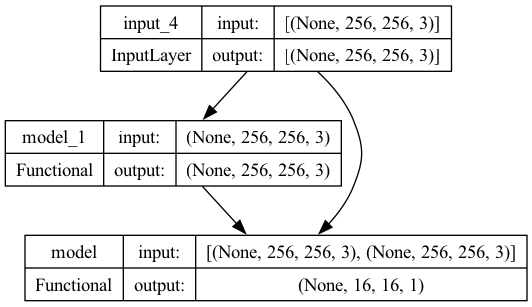

In [5]:
from pix2pix_gan.gan import create_gan

image_shape = (256,256,3)
gan_model = create_gan(
    generator_model=generator_model,
    discriminator_model=discriminator_model,
    image_shape=image_shape,
)

gan_model.summary()
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

## 4. Load Data

In [6]:
import os
import pathlib
import time
import datetime
import tensorflow as tf

from matplotlib import pyplot as plt

dataset_name = "facades"
DATA_PATH = "../data"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

In [7]:
list(PATH.parent.iterdir())
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)


(256, 512, 3)


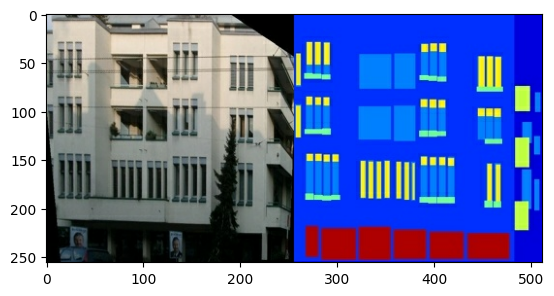

In [8]:
plt.figure()
plt.imshow(sample_image)


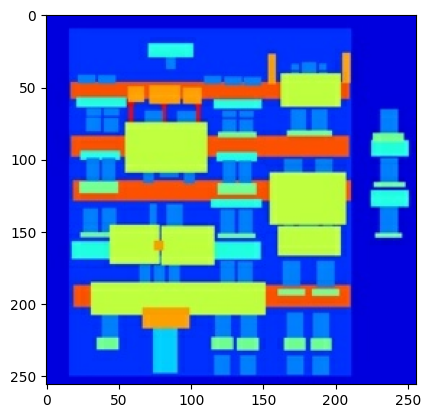

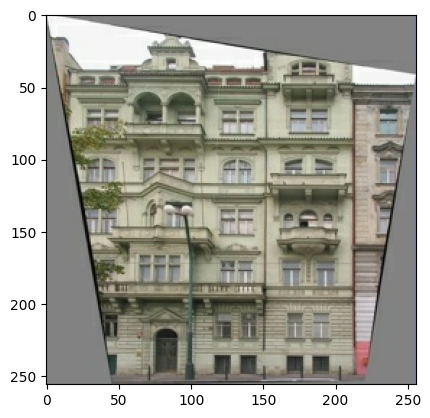

In [9]:
from preprocess.facade_preprocess import load_image

inp, re = load_image(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

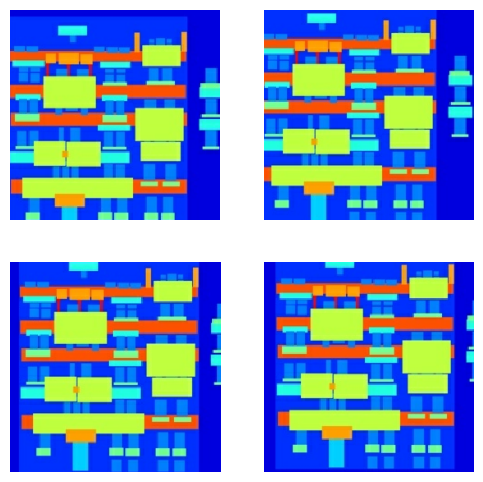

In [10]:
from preprocess.facade_preprocess import random_jitter_preprocess

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter_preprocess(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')

plt.show()

## Defining Methods to Load Data

To load data we need to:

- Load the real image
- Load The input image
- Apply random jittering on both images

In [11]:
from preprocess.facade_preprocess import random_jitter_preprocess, load_image
from collections import namedtuple
from typing import List

TEST_IMAGES = 127

TrainingSample = namedtuple("TestSample", "input_image real_image y")

def get_training_images() -> List[TrainingSample]:
    test_samples: List[TrainingSample] = []
    for i in range(TEST_IMAGES + 1):
        image_number = i + 1
        image_name = f"{image_number}.jpg"
        input_image, real_image = load_image(str(PATH / f'train/{image_name}'))
        input_transformed_image, real_transformed_image = random_jitter_preprocess(input_image, real_image)
        test_samples.append(TrainingSample(input_transformed_image, real_transformed_image, 1))
        
        
    return test_samples

In [12]:
training_real_images = get_training_images()

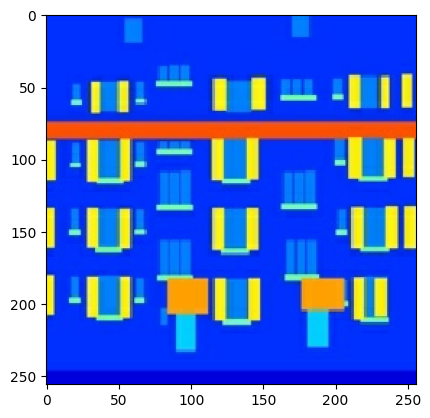

In [13]:
imp_img_5, _, _ = training_real_images[4]
plt.imshow(imp_img_5/255.0)

Generating fake images from the generator network

In [14]:
from keras.models import Model
from typing import Any



class FakeImageGenerator:
    def __init__(self, generator_model: Model):
        self._generator_model = generator_model
        
    def generate_fake_image(self, input_image: str) -> TrainingSample:
        X = self._generator_model.predict(input_image)
        return TrainingSample(input_image=input_image, real_image=X, y=0)

## 6. Define Training Function

In [17]:
def train(
    discriminator_model,
    generator_model,
    gan_model,
    n_epochs: int=100,
    n_batch: int=1,
    n_patch: int=16,
):
    fake_image_generator = FakeImageGenerator(generator_model=generator_model)
    training_real_images = get_training_images()
    training_fake_images = [fake_image_generator.generate_fake_image(inp_img) for (inp_img, _, _) in training_real_images]
    input_image, real_image, real_y = training_real_images
    input_image_fake, fake_image, fake_y = training_fake_images
       

In [18]:
train(
    discriminator_model=discriminator_model,
    generator_model=generator_model,
    gan_model=gan_model,
)

ValueError: in user code:

    File "/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(32, 256, 3)
